In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
DATA_DIR = "../../data/"
DATA_NAME = "bandar_abbas_1_year.csv"

# Load data
df = pd.read_csv(os.path.join(DATA_DIR, DATA_NAME))

In [4]:
df.head()

,Unnamed: 0,datetime,t,td,p,p0,u,vv,n,dd,ff,ww,twet,ew
0,0,2023-03-21 00:00:00,20.300001,17.600000,1004.2,1003.1,84.0,5000.0,3.0,50.0,3.0,10.0,18.6,20.05708
1,1,2023-03-21 03:00:00,20.900000,18.800001,1005.2,1004.0,86.0,3000.0,5.0,360.0,2.0,10.0,19.4,21.31320
2,2,2023-03-21 06:00:00,25.800001,18.300001,1006.4,1005.3,63.0,4000.0,3.0,40.0,4.0,5.0,21.0,21.00323
3,3,2023-03-21 09:00:00,27.300001,19.300001,1005.8,1004.7,62.0,4000.0,7.0,120.0,3.0,5.0,22.1,22.41583
4,4,2023-03-21 12:00:00,27.800001,15.500000,1003.5,1002.4,47.0,7000.0,7.0,250.0,5.0,5.0,20.2,17.57531


In [5]:
df.columns

Index(['Unnamed: 0', 'datetime', 't', 'td', 'p', 'p0', 'u', 'vv', 'n', 'dd',
       'ff', 'ww', 'twet', 'ew'],
      dtype='object')

In [7]:
df = df[[ 'datetime', 't', 'p', 'u', 'dd', 'ff']]

In [8]:
clmns_name = {
    't':'temp',
    'p': 'pressure',
    'u':'humidity',
    'dd':'wind_direction',
    'ff': 'wind_speed'
}

In [11]:
df.rename(columns=clmns_name, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   datetime        2920 non-null   object 
 1   temp            2913 non-null   float64
 2   pressure        2913 non-null   float64
 3   humidity        2912 non-null   float64
 4   wind_direction  2899 non-null   float64
 5   wind_speed      2899 non-null   float64
dtypes: float64(5), object(1)
memory usage: 137.0+ KB


In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,2913.0,27.937728,6.589584,8.70000,23.2,28.4,33.100002,44.2
pressure,2913.0,1008.779987,7.236062,993.10004,1002.6,1009.2,1015.300000,1023.8
humidity,2912.0,63.537775,17.417597,9.00000,53.0,66.0,77.000000,99.0
wind_direction,2899.0,181.231114,104.261703,0.00000,99.0,200.0,250.000000,360.0
wind_speed,2899.0,3.328734,1.656461,0.00000,2.0,3.0,4.000000,12.0


In [14]:
# Check for exact duplicate rows
print("Exact duplicate rows:", df.duplicated().sum())

# Check for duplicates based only on datetime (should be unique)
print("Duplicate datetime entries:", df.duplicated(subset=['datetime']).sum())

# Show duplicated datetime entries (if any)
duplicated_datetimes = df[df.duplicated(subset=['datetime'], keep=False)]
print("\nDuplicated datetime records (if any):")
print(duplicated_datetimes.sort_values('datetime').head(20))

# Check for near-duplicates in datetime (e.g., same minute)
df['datetime_rounded'] = pd.to_datetime(df['datetime']).dt.round('min')
print("\nRows with same rounded minute:", df.duplicated(subset=['datetime_rounded']).sum())

# Optional: inspect time gaps for irregular sampling
df_sorted = df.sort_values('datetime').copy()
df_sorted['time_diff'] = pd.to_datetime(df_sorted['datetime']).diff()
print("\nMost common time intervals:")
print(df_sorted['time_diff'].value_counts().head())

Exact duplicate rows: 0
Duplicate datetime entries: 0

Duplicated datetime records (if any):
Empty DataFrame
Columns: [datetime, temp, pressure, humidity, wind_direction, wind_speed]
Index: []

Rows with same rounded minute: 0

Most common time intervals:
time_diff
0 days 03:00:00    2919
Name: count, dtype: int64


In [15]:
# Identify rows where humidity is still NaN after previous filling
hum_nan_mask = df['humidity'].isna()

# Show count of remaining NaNs
print("Remaining humidity NaNs:", hum_nan_mask.sum())

# Show first few rows with humidity NaN
print("\nFirst 10 rows with humidity NaN:")
df[hum_nan_mask].head(10)

# Check if remaining NaNs are at the start or end
print("\nNaNs in first 100 rows:", hum_nan_mask.iloc[:100].sum())
print("NaNs in last 100 rows:", hum_nan_mask.iloc[-100:].sum())

# Check time gaps around remaining NaNs (to see if part of long gaps)
if hum_nan_mask.sum() > 0:
    nan_df = df[hum_nan_mask].copy()
    print("\nSample datetime range of remaining NaNs:")
    print("Earliest:", nan_df['datetime'].min())
    print("Latest:", nan_df['datetime'].max())

Remaining humidity NaNs: 8

First 10 rows with humidity NaN:

NaNs in first 100 rows: 0
NaNs in last 100 rows: 1

Sample datetime range of remaining NaNs:
Earliest: 2023-04-25 21:00:00
Latest: 2024-03-10 09:00:00


In [16]:
df[hum_nan_mask].head(10)

,datetime,temp,pressure,humidity,wind_direction,wind_speed,datetime_rounded
287,2023-04-25 21:00:00,NaN,NaN,NaN,NaN,NaN,2023-04-25 21:00:00
447,2023-05-15 21:00:00,NaN,NaN,NaN,NaN,NaN,2023-05-15 21:00:00
1171,2023-08-14 09:00:00,NaN,NaN,NaN,NaN,NaN,2023-08-14 09:00:00
1547,2023-09-30 09:00:00,NaN,NaN,NaN,NaN,NaN,2023-09-30 09:00:00
1695,2023-10-18 21:00:00,NaN,NaN,NaN,NaN,NaN,2023-10-18 21:00:00
2135,2023-12-12 21:00:00,NaN,NaN,NaN,NaN,NaN,2023-12-12 21:00:00
2263,2023-12-28 21:00:00,NaN,NaN,NaN,NaN,NaN,2023-12-28 21:00:00
2843,2024-03-10 09:00:00,25.8,1016.0,NaN,180.0,4.0,2024-03-10 09:00:00


In [17]:
# Ensure datetime is in correct datetime type and sort
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)

# Set datetime as index for time-based interpolation
df = df.set_index('datetime')

# Drop the helper column used earlier
df = df.drop(columns=['datetime_rounded'], errors='ignore')

# Time-based interpolation for remaining NaNs in all numeric columns
df = df.interpolate(method='time')

# Optional: forward/backward fill any remaining edge NaNs
df = df.ffill().bfill()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2920 entries, 2023-03-21 00:00:00 to 2024-03-19 21:00:00
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp            2920 non-null   float64
 1   pressure        2920 non-null   float64
 2   humidity        2920 non-null   float64
 3   wind_direction  2920 non-null   float64
 4   wind_speed      2920 non-null   float64
dtypes: float64(5)
memory usage: 136.9 KB


In [21]:
# 1. Ensure datetime index is sorted (already done, but safe to confirm)
assert df.index.is_monotonic_increasing, "Datetime index is not sorted!"

# 2. Calculate time differences between consecutive rows
time_diffs = df.index.to_series().diff()

# 3. Show unique time intervals and their frequencies
print("Most common time intervals:")
print(time_diffs.value_counts().head(10))

# 4. Check for unexpected gaps (e.g., > 180 minutes)
expected_freq = pd.Timedelta(minutes=10)  # adjust if your data has different freq
large_gaps = time_diffs[time_diffs > pd.Timedelta(minutes=180)]
print(f"\nNumber of large gaps (>180 min): {len(large_gaps)}")
if len(large_gaps) > 0:
    print("First few large gaps:")
    print(large_gaps.head())

# 5. Check for duplicate timestamps
duplicated_times = df.index.duplicated()
print(f"\nNumber of duplicate timestamps: {duplicated_times.sum()}")

Most common time intervals:
datetime
0 days 03:00:00    2919
Name: count, dtype: int64

Number of large gaps (>180 min): 0

Number of duplicate timestamps: 0


In [22]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,2920.0,27.936319,6.594990,8.70000,23.2,28.4,33.100002,44.2
pressure,2920.0,1008.780309,7.232227,993.10004,1002.6,1009.2,1015.225000,1023.8
humidity,2920.0,63.540411,17.415865,9.00000,53.0,66.0,77.000000,99.0
wind_direction,2920.0,181.235788,104.083394,0.00000,99.0,200.0,250.000000,360.0
wind_speed,2920.0,3.328253,1.653489,0.00000,2.0,3.0,4.000000,12.0


Basic statistics:
              temp     pressure     humidity  wind_direction   wind_speed
count  2920.000000  2920.000000  2920.000000     2920.000000  2920.000000
mean     27.936319  1008.780309    63.540411      181.235788     3.328253
std       6.594990     7.232227    17.415865      104.083394     1.653489
min       8.700000   993.100040     9.000000        0.000000     0.000000
25%      23.200000  1002.600000    53.000000       99.000000     2.000000
50%      28.400000  1009.200000    66.000000      200.000000     3.000000
75%      33.100002  1015.225000    77.000000      250.000000     4.000000
max      44.200000  1023.800000    99.000000      360.000000    12.000000

Lag-1 autocorrelation (values >0.8 typical for temp/pressure/humidity):
temp          0.881214
pressure      0.985164
humidity      0.712554
wind_speed    0.465361
dtype: float64


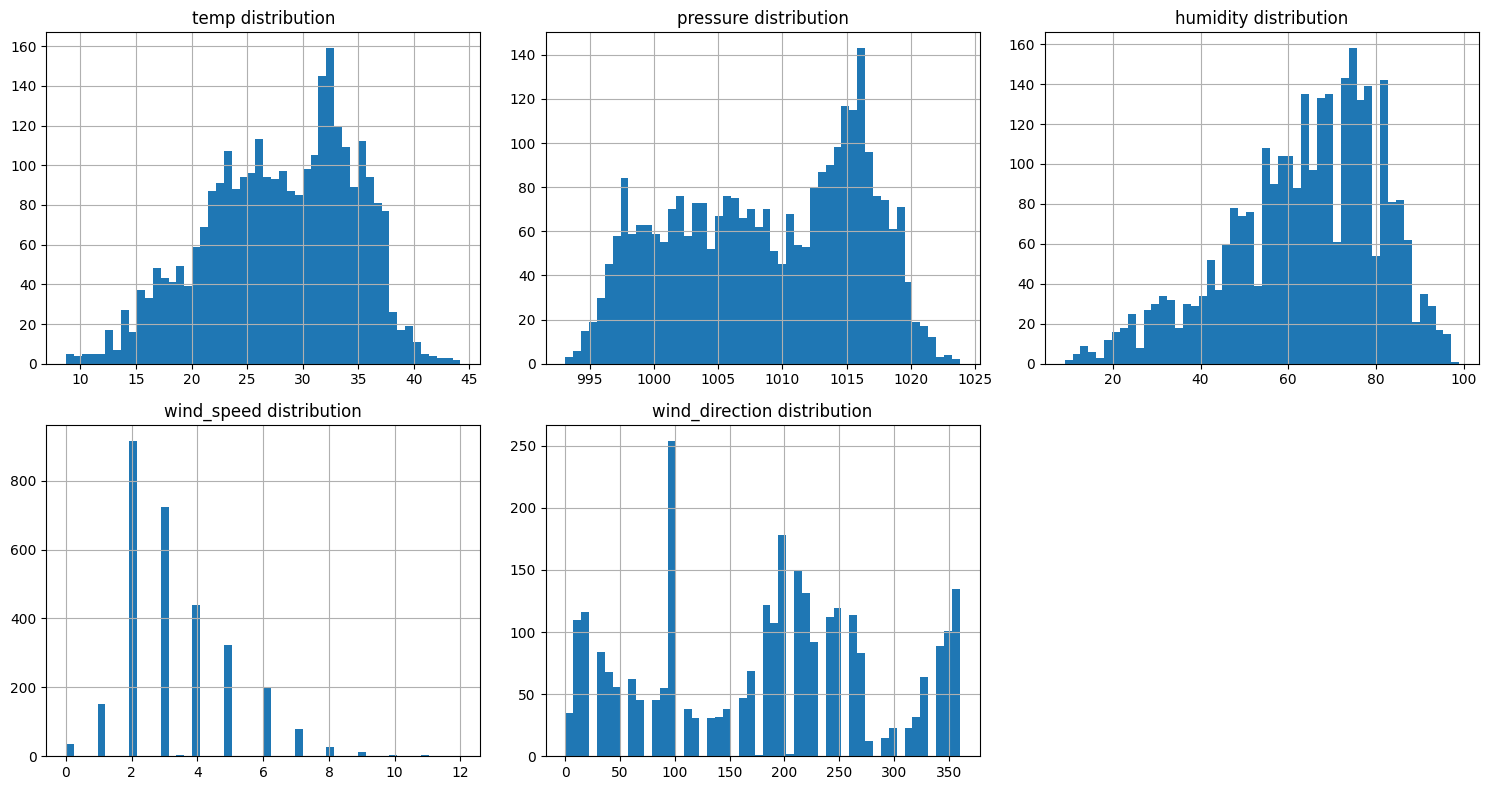


Percentage of zero wind speed readings: 1.20%
Wind direction = 0°: 35 occurrences
Wind direction = 360°: 135 occurrences


In [23]:
import matplotlib.pyplot as plt

# 1. Basic statistics
print("Basic statistics:")
print(df.describe())

# 2. Lag-1 autocorrelation (expected to be high for meteorological variables)
print("\nLag-1 autocorrelation (values >0.8 typical for temp/pressure/humidity):")
autocorr = df[['temp', 'pressure', 'humidity', 'wind_speed']].apply(lambda x: x.autocorr(lag=1))
print(autocorr)

# 3. Histograms to identify anomalies or unrealistic distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
cols = ['temp', 'pressure', 'humidity', 'wind_speed', 'wind_direction']
for i, col in enumerate(cols):
    ax = axes[i // 3, i % 3]
    df[col].hist(bins=50, ax=ax)
    ax.set_title(f'{col} distribution')
# Hide unused subplot
axes[1, 2].set_visible(False)
plt.tight_layout()
plt.show()

# 4. Check for excessive zero wind speed (some calm periods are normal; very high % may indicate issues)
zero_wind_pct = (df['wind_speed'] == 0).mean() * 100
print(f"\nPercentage of zero wind speed readings: {zero_wind_pct:.2f}%")

# 5. Wind direction sanity check: 0° and 360° are equivalent; excess of either may indicate default/fill values
wind_dir_0 = (df['wind_direction'] == 0).sum()
wind_dir_360 = (df['wind_direction'] == 360).sum()
print(f"Wind direction = 0°: {wind_dir_0} occurrences")
print(f"Wind direction = 360°: {wind_dir_360} occurrences")

In [24]:
import numpy as np

# 1. Convert Meteorological Degrees to Radians for Math
# Formula: (270 - degrees) aligns Meteo North (0) to Math North (90)
wd_rad = np.deg2rad(270 - df['wind_direction'])

# 2. Calculate U and V
# U = East-West component, V = North-South component
df['u'] = df['wind_speed'] * np.cos(wd_rad)
df['v'] = df['wind_speed'] * np.sin(wd_rad)

/tmp/ipykernel_39072/1320987420.py:21: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_30d = df.last('30D')


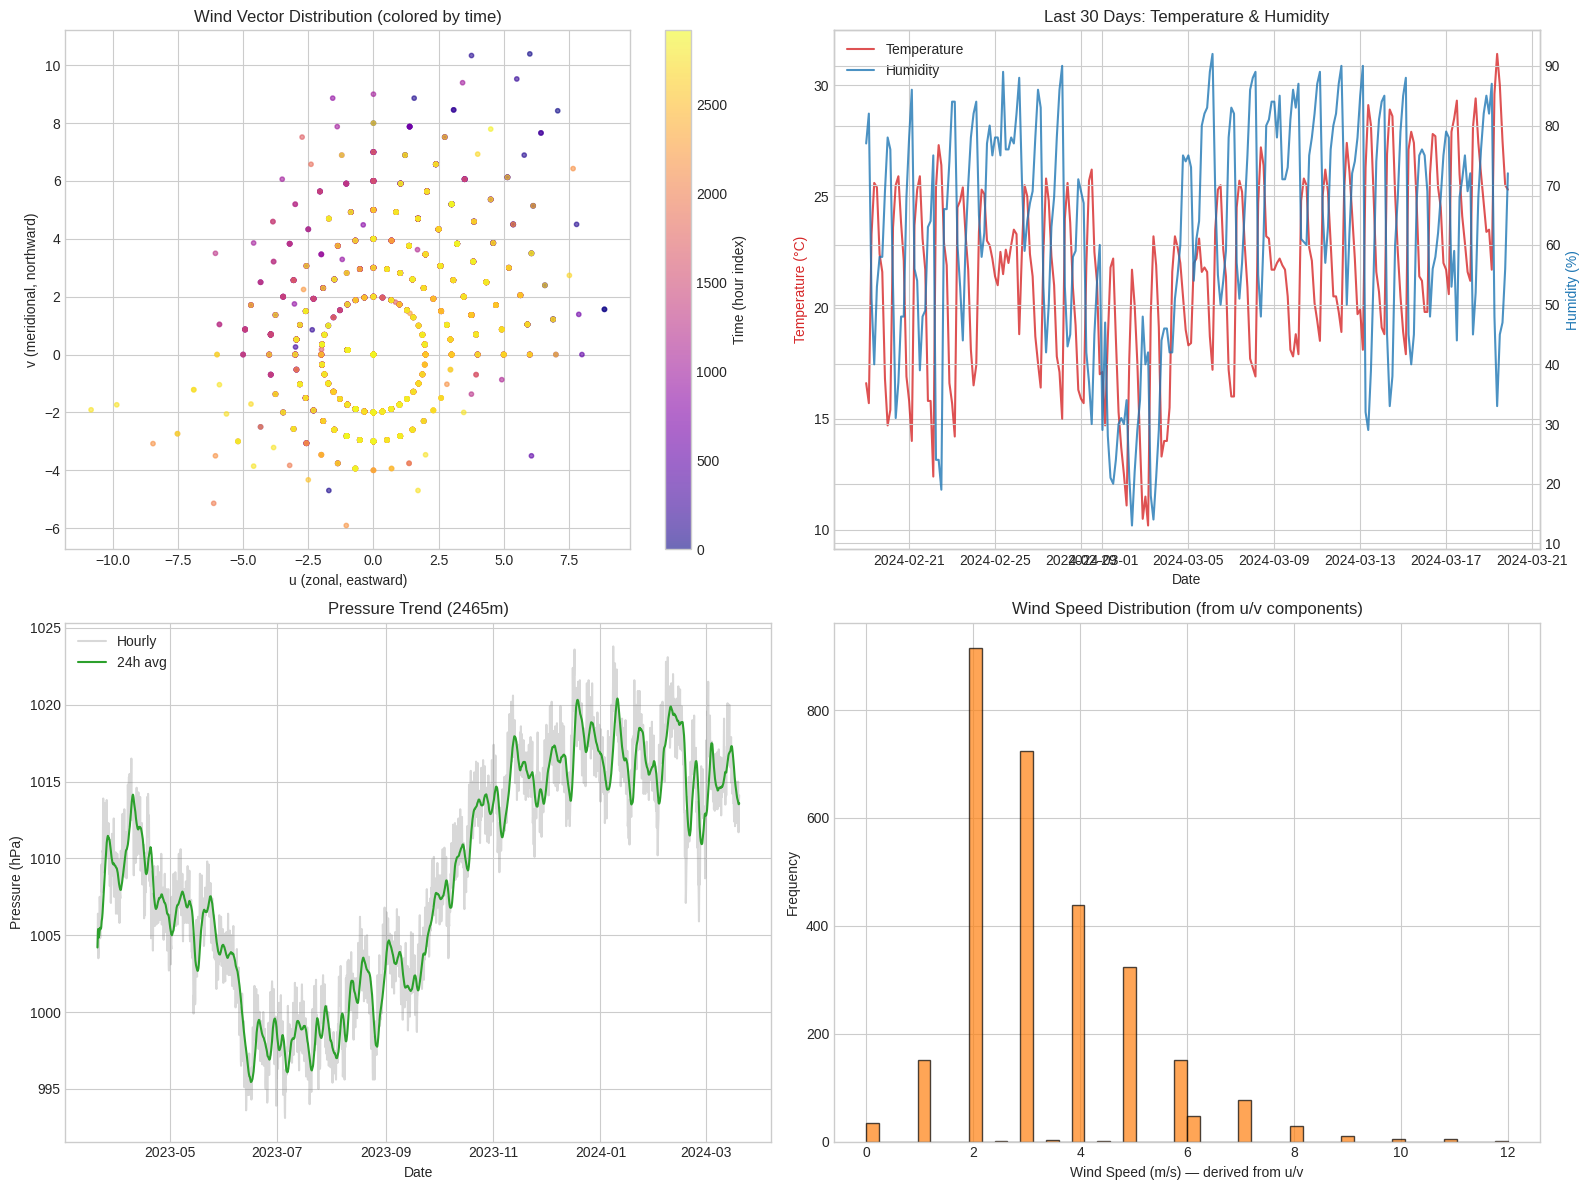

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("tab10")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Wind vectors (u vs v) colored by time index
sc = axes[0, 0].scatter(df['u'], df['v'], 
                        c=range(len(df)), cmap='plasma', alpha=0.6, s=10)
axes[0, 0].set_xlabel('u (zonal, eastward)')
axes[0, 0].set_ylabel('v (meridional, northward)')
axes[0, 0].set_title('Wind Vector Distribution (colored by time)')
plt.colorbar(sc, ax=axes[0, 0], label='Time (hour index)')

# 2. Temperature and humidity over last 30 days
last_30d = df.last('30D')
ax2 = axes[0, 1].twinx()
ln1 = axes[0, 1].plot(last_30d.index, last_30d['temp'], 
                      color='tab:red', label='Temperature', alpha=0.8)
ln2 = ax2.plot(last_30d.index, last_30d['humidity'], 
               color='tab:blue', label='Humidity', alpha=0.8)
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Temperature (°C)', color='tab:red')
ax2.set_ylabel('Humidity (%)', color='tab:blue')
axes[0, 1].set_title('Last 30 Days: Temperature & Humidity')
lines = ln1 + ln2
labels = [l.get_label() for l in lines]
axes[0, 1].legend(lines, labels, loc='upper left')

# 3. Pressure trend with 24-hour rolling mean
df['pressure_24h'] = df['pressure'].rolling(window=24, min_periods=1).mean()
axes[1, 0].plot(df.index, df['pressure'], alpha=0.3, color='gray', label='Hourly')
axes[1, 0].plot(df.index, df['pressure_24h'], color='tab:green', label='24h avg')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Pressure (hPa)')
axes[1, 0].set_title('Pressure Trend (2465m)')
axes[1, 0].legend()

# 4. Wind speed distribution computed from u and v components
wind_speed_from_uv = np.sqrt(df['u']**2 + df['v']**2)
axes[1, 1].hist(wind_speed_from_uv, bins=50, color='tab:orange', alpha=0.7, edgecolor='k')
axes[1, 1].set_xlabel('Wind Speed (m/s) — derived from u/v')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Wind Speed Distribution (from u/v components)')

plt.tight_layout()
plt.show()

In [28]:
df.head()

,temp,pressure,humidity,wind_direction,wind_speed,u,v,pressure_24h
datetime,,,,,,,,
2023-03-21 00:00:00,20.300001,1004.2,84.0,50.0,3.0,-2.298133e+00,-1.928363,1004.200000
2023-03-21 03:00:00,20.900000,1005.2,86.0,360.0,2.0,1.224647e-16,-2.000000,1004.700000
2023-03-21 06:00:00,25.800001,1006.4,63.0,40.0,4.0,-2.571150e+00,-3.064178,1005.266667
2023-03-21 09:00:00,27.300001,1005.8,62.0,120.0,3.0,-2.598076e+00,1.500000,1005.400000
2023-03-21 12:00:00,27.800001,1003.5,47.0,250.0,5.0,4.698463e+00,1.710101,1005.020000


In [29]:
import os

# ===========================
# 6-d. EXPORT HOURLY CLEAN CSV
# ===========================
out_dir = '../../data/cleaned/'
os.makedirs(out_dir, exist_ok=True)
output_path = os.path.join(out_dir, 'bandarAbas_multi_var_wind_3hourly_cleaned.csv')
df.to_csv(output_path)

print("✅ Multi-variate 3hourly clean file saved to:", output_path)
print("Shape written:", df.shape)

✅ Multi-variate 3hourly clean file saved to: ../../data/cleaned/bandarAbas_multi_var_wind_3hourly_cleaned.csv
Shape written: (2920, 8)
